## Create a Knapsack Problem Instance

In [1]:
from knapsack import Knapsack
from WCGGA import run_WCGGA
from CGGA_New import run_CGGA
# Create an instance of a Knapsack problem
p_file = "Knapsack_Problems/problemInstances/n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300/test.in"
opt_file = "Knapsack_Problems/optima.csv"
knapsack = Knapsack(p_file, opt_file)

n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_

In [1]:
import pandas as pd
import numpy as np
import time
import json
import multiprocessing
from joblib import Parallel, delayed  # <--- NEW IMPORTS
from knapsack import Knapsack
from WCGGA import run_WCGGA
from CGGA_New import run_CGGA

# 1. SETUP CONFIGURATION
PROBLEMS = [
    # Path, Optimal Value
    ("Knapsack_Problems/problemInstances/n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300/test.in", 1036114),
    ("Knapsack_Problems/problemInstances/n_800_c_10000000000_g_10_f_0.3_eps_0_s_200/test.in", 9980515157),
    ("Knapsack_Problems/problemInstances/n_1000_c_1000000_g_14_f_0.2_eps_0.1_s_200/test.in", 1008699),
    ("Knapsack_Problems/problemInstances/n_1000_c_1000000_g_2_f_0.3_eps_1e-05_s_200/test.in", 528690),
    ("Knapsack_Problems/problemInstances/n_600_c_100000000_g_2_f_0.3_eps_0.01_s_300/test.in", 51026718),
]

SEEDS = list(range(30))
ALGORITHMS = ["WCGGA", "CGGA"]

PARAMS = {
    "pop_size": 2400,
    "max_time": 1200,
    "max_generations": 10000,
    "stagnation_limit": 75,
    "initialization_feasability": 0.3
}

results_data = []
history_data = []

# ==========================================
# 2. DEFINE THE WORKER FUNCTION
#    (This replaces the code inside your old loop)
# ==========================================
def run_single_experiment(algo_name, p_path, optimal_value, seed, params):
    """
    Runs one algorithm on one problem with one seed.
    Returns the summary dict and the history dict.
    """
    # Re-initialize knapsack inside the worker process (Critical for pickling)
    local_knapsack = Knapsack(p_path)
    mutation_prob = 4.0 / len(local_knapsack)

    start_wall_time = time.time()

    # Run the specific algorithm
    if algo_name == "WCGGA":
        res = run_WCGGA(
            local_knapsack,
            pop_size=params["pop_size"],
            crossover_probability=0.9,
            mutation_probability=mutation_prob,
            max_time=params["max_time"],
            max_generations=params["max_generations"],
            stagnation_limit=params["stagnation_limit"],
            initialization_feasability=params["initialization_feasability"],
            random_seed=seed
        )
    else: # CGGA
        res = run_CGGA(
            local_knapsack,
            pop_size=params["pop_size"],
            crossover_probability=0.9,
            mutation_probability=mutation_prob,
            max_time=params["max_time"],
            max_generations=params["max_generations"],
            stagnation_limit=params["stagnation_limit"],
            initialization_feasability=params["initialization_feasability"],
            random_seed=seed,
            migration_size=3,
            migration_frequency=20
        )

    end_wall_time = time.time()
    duration = end_wall_time - start_wall_time

    # --- Extract Metrics ---
    # Note: Use 'best_individual' or 'hof' depending on what your function returns
    # If using HOF version: best_fitness = res['hof'][0].fitness.values[0]
    best_fitness = res['best_individual'].fitness.values[0]

    gap = ((optimal_value - best_fitness) / optimal_value) * 100
    target_95 = optimal_value * 0.95
    gens_to_95 = next((i for i, v in enumerate(res['max_values']) if v >= target_95), None)

    # 1. Summary Record
    summary_record = {
        "Algorithm": algo_name,
        "Problem": p_path.split('/')[-2],
        "Seed": seed,
        "Best_Fitness": best_fitness,
        "Optimal": optimal_value,
        "Gap_Percent": gap,
        "Time_Seconds": duration,
        "Generations_Run": len(res['max_values']),
        "Gens_to_95_Percent": gens_to_95,
        "Final_Diversity": res.get('diversity_history', [-1])[-1]
    }

    # 2. History Record
    history_record = {
        "Algorithm": algo_name,
        "Problem": p_path.split('/')[-2],
        "Seed": seed,
        "Fitness_Curve": [float(x) for x in res['max_values']],
        "Diversity_Curve": [float(x) for x in res.get('diversity_history', [])]
    }

    return summary_record, history_record


# ==========================================
# 3. THE PARALLEL EXECUTION BLOCK
# ==========================================
if __name__ == "__main__":
    # Determine cores (leave 2 free for OS tasks)
    num_cores = 8
    print(f"Starting Parallel Benchmark on {num_cores} cores...")

    # Create the job queue
    jobs = []
    for p_path, optimal_value in PROBLEMS:
        for algo_name in ALGORITHMS:
            for seed in SEEDS:
                # Pack arguments into a tuple
                jobs.append((algo_name, p_path, optimal_value, seed, PARAMS))

    print(f"Queueing {len(jobs)} total runs...")

    # Execute!
    # verbose=10 gives you a progress bar in the terminal
    results = Parallel(n_jobs=num_cores, verbose=10)(
        delayed(run_single_experiment)(*job) for job in jobs
    )

    # Unpack the results
    for summary, history in results:
        results_data.append(summary)
        history_data.append(history)

    # ==========================================
    # 4. SAVE RESULTS
    # ==========================================
    timestamp = time.strftime("%Y%m%d-%H%M%S")

    # A. CSV
    df = pd.DataFrame(results_data)
    csv_filename = f"benchmark_results_{timestamp}.csv"
    df.to_csv(csv_filename, index=False)

    # B. JSON
    json_filename = f"benchmark_history_{timestamp}.json"
    with open(json_filename, 'w') as f:
        json.dump(history_data, f)

    print(f"\nBenchmark Complete.")
    print(f"Summary saved to: {csv_filename}")
    print(f"Curves saved to: {json_filename}")

Starting Parallel Benchmark on 8 cores...
Queueing 300 total runs...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 20.0min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 40.0min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 40.1min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 80.0min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 100.1min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 120.1min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 140.2min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 180.2min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 220.1min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 260.2min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 280.3min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 340.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 380.3min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 420.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 460.4min


Benchmark Complete.
Summary saved to: benchmark_results_20251215-073056.csv
Curves saved to: benchmark_history_20251215-073056.json


C:\Users\Alex Rubin\AppData\Local\Temp\ipykernel_19432\651697176.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x="Algorithm", y="Gap_Percent", palette=palette, ax=ax3, showfliers=False)
C:\Users\Alex Rubin\AppData\Local\Temp\ipykernel_19432\651697176.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x="Algorithm", y="Final_Diversity", palette=palette, ax=ax5, showfliers=False)


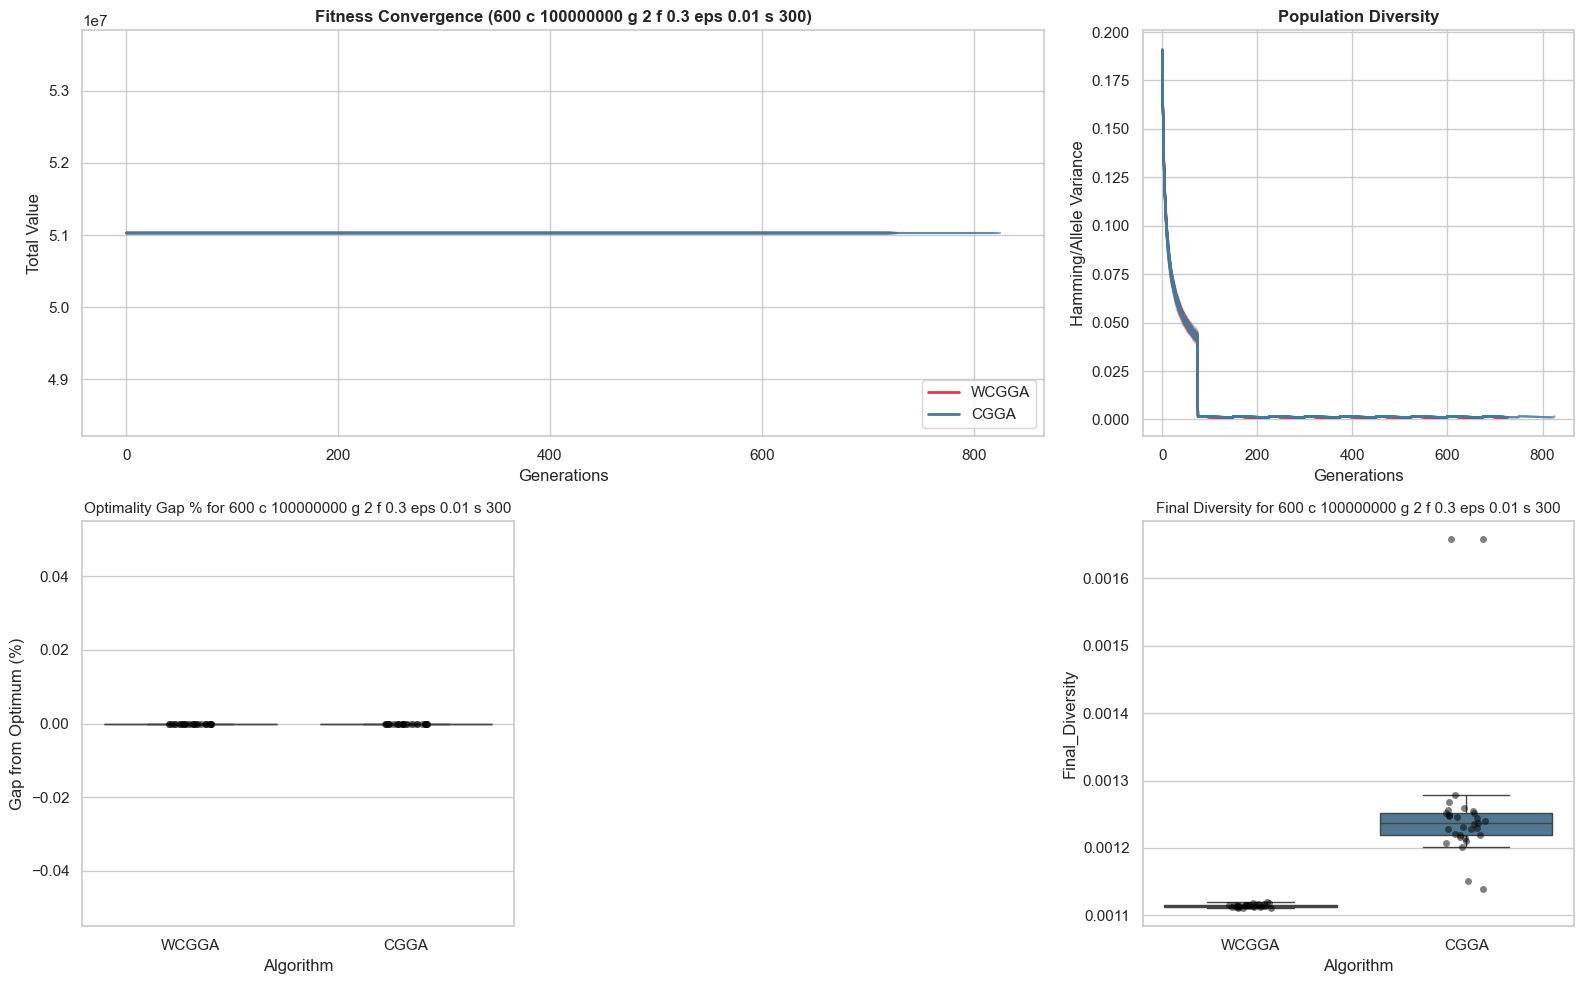

In [10]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
# Fix Optimality Gap Graph - DONE
# Optimality over time
# Fitness over time - Limit Y axis from min value to max value
# WilCox Ranksum Test, P-Value: https://astatsa.com/WilcoxonTest/
    # Enter the final settled optimal value for each problem instance (i.e. the 10 runs)
# New problem-set: https://hjemmesider.diku.dk/~pisinger/codes.html
# Fix Nuke logic

# ==========================================
# 1. LOAD THE DATA
# ==========================================

# A. Load History (JSON) - For Curves
# (Assuming file exists, using the filename you provided)
json_filename = "benchmark_history_20251215-073056.json"
csv_filename = "benchmark_results_20251215-073056.csv"
problem_id = "n_600_c_100000000_g_2_f_0.3_eps_0.01_s_300"
try:
    with open(json_filename, "r") as f:
        history_data = json.load(f)
except FileNotFoundError:
    # Fallback dummy data for demonstration if file missing
    history_data = []

# B. Load Summary (CSV) - For Boxplots
# I am using io.StringIO to read your text snippet directly.
# In production, use: df = pd.read_csv("benchmark_results_....csv")
df = pd.read_csv(csv_filename)

# ==========================================
# 2. SETUP THE DASHBOARD
# ==========================================
# Set a professional style
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3) # 2 Rows, 3 Columns

# ==========================================
# 3. PLOT CURVES (Top Row)
# ==========================================


# 1. Filter the History Data (For Curves)
history_subset = [d for d in history_data if d.get('Problem') == problem_id]

# 2. Filter the Summary Data (For Boxplots)
df_filtered = df[df['Problem'] == problem_id].copy() # .copy() avoids warnings

# Define Palette
palette = {"WCGGA": "#E63946", "CGGA": "#457B9D"}
problem_title = problem_id.replace('_', ' ').split(' ', 1)[1] # Optional: Clean up title

# ==========================================
# 3. PLOT CURVES (Top Row)
# ==========================================

# --- A. Fitness Convergence (Top Left) ---
ax1 = fig.add_subplot(gs[0, :2]) # Span 2 columns

# 1. Plot the Data
for run in history_subset:
    color = palette[run['Algorithm']]
    ax1.plot(run['Fitness_Curve'], color=color, alpha=0.4, linewidth=1.5)

# 2. Add Legend and Titles (RE-ADDING MISSING CODE)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#E63946', lw=2),
                Line2D([0], [0], color='#457B9D', lw=2)]
ax1.legend(custom_lines, ['WCGGA', 'CGGA'], loc='lower right')
ax1.set_title(f"Fitness Convergence ({problem_title})", fontsize=12, fontweight='bold')
ax1.set_xlabel("Generations")
ax1.set_ylabel("Total Value")


# --- B. Diversity Decay (Top Right) ---
ax2 = fig.add_subplot(gs[0, 2]) # Span 1 column

for run in history_subset:
    color = palette[run['Algorithm']]
    if 'Diversity_Curve' in run and len(run['Diversity_Curve']) > 0:
        ax2.plot(run['Diversity_Curve'], color=color, alpha=0.4, linewidth=1.5)

ax2.set_title("Population Diversity", fontsize=12, fontweight='bold')
ax2.set_xlabel("Generations")
ax2.set_ylabel("Hamming/Allele Variance")

# WARNING: Remove plt.ylim() unless you absolutely need it, as it can hide data
# plt.ylim(560000, 570000) # This line was in your previous snippet, remove if possible!

# ==========================================
# 4. PLOT STATS (Bottom Row)
# ==========================================

# Define Palette
palette = {"WCGGA": "#E63946", "CGGA": "#457B9D"}
problem_title = problem_id.replace('_', ' ').split(' ', 1)[1] # Optional: Clean up title

# --- C. Optimality Gap (Lower Left) ---
ax3 = fig.add_subplot(gs[1, 0])
# FIX: Use df_filtered here!
sns.boxplot(data=df_filtered, x="Algorithm", y="Gap_Percent", palette=palette, ax=ax3, showfliers=False)
sns.stripplot(data=df_filtered, x="Algorithm", y="Gap_Percent", color="black", alpha=0.5, ax=ax3)
ax3.set_title(f"Optimality Gap % for {problem_title}", fontsize=11)
ax3.set_ylabel("Gap from Optimum (%)")


# --- E. Final Diversity (Lower Right) ---
ax5 = fig.add_subplot(gs[1, 2])
# FIX: Use df_filtered here!
sns.boxplot(data=df_filtered, x="Algorithm", y="Final_Diversity", palette=palette, ax=ax5, showfliers=False)
sns.stripplot(data=df_filtered, x="Algorithm", y="Final_Diversity", color="black", alpha=0.5, ax=ax5)
ax5.set_title(f"Final Diversity for {problem_title}", fontsize=11)

plt.tight_layout()
plt.show()